# Spatio-temporal buffer analysis

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors

import pylandstats as pls

# let us use a custom colormap
custom_cmap = colors.ListedColormap([
    (0, 0, 0, 0),
    (0.6, 0, 0, 1),
    (.95, .9, .75, 1),
], N=3)
cm.register_cmap(name='custom', cmap=custom_cmap)
plt.rcParams['image.cmap'] = 'custom'

Landscape metrics are very sensitive to scale, that is, to the pixel resolution and especially to the spatial extent of the considered map. Rather than restricting our analyses to a specific map extent, we are often interested in assessing how landacape patterns respond to a variety of definitions of the spatial extent. While the `ZonalAnalysis` and `BufferAnalysis` classes are designed to such purpose, we might also want to evaluate how the computed time series of metrics responds to changes in the map extent. This is why PyLandStats features an additional `SpatioTemporalBufferAnalysis` analysis class.

Like in the [Spatio-temporal analysis example](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/02-spatiotemporal-analysis.ipynb), we will use the three extracts of the Canton of Vaud from the [CORINE Land Cover datasets](https://land.copernicus.eu/pan-european/corine-land-cover) for the years 2000, 2006 and 2012, yet in this case we also need to specify how the buffers are constructed. Let us consider three buffers of 10, 15 and 20km around the center of Lausanne:

In [2]:
from shapely.geometry import Point

input_filepaths = [
    '../data/clc/vaud_g100_clc00_V18_5.tif',
    '../data/clc/vaud_g100_clc06_V18_5a.tif',
    '../data/clc/vaud_g100_clc12_V18_5a.tif'
]

# latitude and longitude of the center of Lausanne according to OpenStreetMap
base_mask = Point(6.6327025, 46.5218269)
base_mask_crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

# buffer distances (in meters)
buffer_dists = [10000, 15000, 20000]

stba = pls.SpatioTemporalBufferAnalysis(
    input_filepaths, base_mask, buffer_dists, base_mask_crs=base_mask_crs,
    dates=[2000, 2006, 2012])

Analogously to `BufferAnalysis`, we could also initialize the from a polygon geometry (such an administrative boundary) by passing such object as the `base_mask` argument. See [the zonal analysis notebook](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/03-zonal-analysis.ipynb) to see how this can be done

Like `SpatioTemporalAnalysis`, `BufferAnalysis` and/or `ZonalAnalysis`, we can compute the data frame of class metrics through the `compute_class_metrics_df` method:

In [3]:
class_metrics_df = stba.compute_class_metrics_df()
class_metrics_df.head()

metric                      total_area proportion_of_landscape  \
buffer_dist class_val dates                                      
10000       1         2000        7261                 24.9648   
                      2006        7205                 24.7722   
                      2012        7205                 24.7722   
            2         2000       21824                 75.0352   
                      2006       21880                 75.2278   

metric                      number_of_patches patch_density  \
buffer_dist class_val dates                                   
10000       1         2000                 20      0.068764   
                      2006                 20      0.068764   
                      2012                 20      0.068764   
            2         2000                  4     0.0137528   
                      2006                  4     0.0137528   

metric                      largest_patch_index total_edge edge_density  \
buffer_dist class_val dates                                               
10000       1         2000              21.5472     223900      7.69813   
                      2006              21.0211     226600      7.79096   
                      2012              21.0211     227000      7.80471   
            2         2000              74.3614     223900      7.69813   
                      2006              74.5539     226600      7.79096   

metric                      landscape_shape_index area_mn  area_am  ...  \
buffer_dist class_val dates                                         ...   
10000       1         2000                6.74269  363.05  5421.13  ...   
                      2006                6.85294  360.25  5201.63  ...   
                      2012                6.86471  360.25   5201.6  ...   
            2         2000                4.96622    5456  21434.8  ...   
                      2006                5.01689    5470  21490.8  ...   

metric                      fractal_dimension_md fractal_dimension_ra  \
buffer_dist class_val dates                                             
10000       1         2000               1.08318             0.163172   
                      2006               1.08476             0.159439   
                      2012               1.08476             0.159609   
            2         2000               1.06453             0.134831   
                      2006               1.06453             0.135784   

metric                      fractal_dimension_sd fractal_dimension_cv  \
buffer_dist class_val dates                                             
10000       1         2000             0.0434689               4.0267   
                      2006             0.0437442              4.03719   
                      2012             0.0438365              4.04554   
            2         2000             0.0538049              4.98227   
                      2006             0.0541716              5.01513   

metric                      euclidean_nearest_neighbor_mn  \
buffer_dist class_val dates                                 
10000       1         2000                        633.891   
                      2006                         622.71   
                      2012                        613.522   
            2         2000                        211.803   
                      2006                        211.803   

metric                      euclidean_nearest_neighbor_am  \
buffer_dist class_val dates                                 
10000       1         2000                        278.966   
                      2006                        279.997   
                      2012                        278.318   
            2         2000                        200.209   
                      2006                        200.208   

metric                      euclidean_nearest_neighbor_md  \
buffer_dist class_val dates                                 
10000       1         2000               

Note that in this case, the data frame features a three-level [MultiIndex] that distinguishes the computed value for each buffer distances, class values, and date. Again, we can operate upon such data frames as we would do with any other pandas data frame. For instance, we might want to evaluate the difference between the area-weighted fractal dimension of urban patches (represented by a `class_val` of 1) computed at the extent of a 20km buffer and a 10km buffer:

In [4]:
class_metrics_df.loc[(20000, 1), 'fractal_dimension_am'] - \
    class_metrics_df.loc[(10000, 1), 'fractal_dimension_am']

dates
2000   -0.0114821
2006   -0.0131772
2012   -0.0134208
Name: fractal_dimension_am, dtype: object

We can also obtain the data frame of landscape metrics can be obtained as follows:

In [5]:
stba.compute_landscape_metrics_df()

metric            total_area number_of_patches patch_density  \
buffer_dist dates                                              
10000       2000       29085                24     0.0825168   
            2006       29085                24     0.0825168   
            2012       29085                24     0.0825168   
15000       2000       57628                50     0.0867634   
            2006       57628                53     0.0919692   
            2012       57628                54     0.0937044   
20000       2000       91020                81     0.0889914   
            2006       91020                84     0.0922874   
            2012       91020                86     0.0944847   

metric            largest_patch_index total_edge edge_density  \
buffer_dist dates                                               
10000       2000              74.3614     223900      7.69813   
            2006              74.5539     226600      7.79096   
            2012              74.5539     227000      7.80471   
15000       2000              82.9493     395200      6.85778   
            2006              83.5601     391300       6.7901   
            2012              83.4872     395500      6.86298   
20000       2000              86.3151     565200      6.20962   
            2006              86.6678     566200      6.22061   
            2012               86.604     571400      6.27774   

metric            landscape_shape_index  area_mn  area_am area_md  ...  \
buffer_dist dates                                                  ...   
10000       2000                 4.3962  1211.88    17437    49.5  ...   
            2006                4.43567  1211.88  17455.6    51.5  ...   
            2012                4.44152  1211.88  17455.6      51  ...   
15000       2000                 5.3368  1152.56  40426.1      42  ...   
            2006                5.29626  1087.32    40974      41  ...   
            2012                5.33992  1067.19  40903.9      41  ...   
20000       2000                 6.2351   1123.7  68328.4      40  ...   
            2006                6.24338  1083.57  68848.1      41  ...   
            2012                6.28642  1058.37  68747.6      41  ...   

metric            fractal_dimension_sd fractal_dimension_cv  \
buffer_dist dates                                             
10000       2000             0.0453557              4.20122   
            2006              0.045665              4.21665   
            2012               0.04575              4.22432   
15000       2000              0.033956              3.12948   
            2006             0.0360281              3.32371   
            2012             0.0362066              3.34156   
20000       2000              0.036423              3.36974   
            2006             0.0376041              3.47838   
            2012             0.0379647              3.51409   

metric            euclidean_nearest_neighbor_mn euclidean_nearest_neighbor_am  \
buffer_dist dates                                                               
10000       2000                        563.543                        219.87   
            2006                        554.226                       219.974   
            2012                        546.569                       219.558   
15000       2000                        724.862                       244.398   
            2006                        735.306                       244.286   
            2012                        730.934                       244.393   
20000       2000                        788.841                        224.95   
            2006                        773.521                        225.39   
            2012                        763.662                       225.498   

metric            euclidean_nearest_neighbor_md euclidean_nearest_neighbor_ra  \
buffer_dist dates                                                               
10000       2000

Likewise in the other classes of PyLandStats, if we want to compute the metrics data frame only for a subset of metrics or classes, or customize how the metrics are computed, we must respectively pass the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods of `SpatioTemporalBufferAnalysis` as in:

In [6]:
metrics=['proportion_of_landscape', 'edge_density', 'fractal_dimension_am']
classes=[1]
metrics_kws={
    'proportion_of_landscape': {'percent': False },
    'edge_density': {'count_boundary': True}
}
stba.compute_class_metrics_df(
    metrics=metrics, classes=classes, metrics_kws=metrics_kws)

metric                      proportion_of_landscape edge_density  \
buffer_dist class_val dates                                        
10000       1         2000                 0.249648      7.92849   
                      2006                 0.247722        8.011   
                      2012                 0.247722      8.02476   
15000       1         2000                 0.167106       6.9376   
                      2006                 0.160998      6.86472   
                      2012                 0.161727       6.9376   
20000       1         2000                 0.133476      6.29532   
                      2006                 0.129938      6.30411   
                      2012                 0.130543      6.36563   

metric                      fractal_dimension_am  
buffer_dist class_val dates                       
10000       1         2000               1.15432  
                      2006               1.15055  
                      2012               1.15074  
15000       1         2000               1.14603  
                      2006               1.14374  
                      2012               1.14356  
20000       1         2000               1.14283  
                      2006               1.13737  
                      2012               1.13732

## Plots

Perhaps the most important functionality of the `SpatioTemporalBufferAnalysis` is plotting the time series of metrics at each spatial extent. We can accomplish that through the `plot_metric` method. For instance, let us plot the proportion of landscape at the level of the *urban* class (`class_val` of 1):

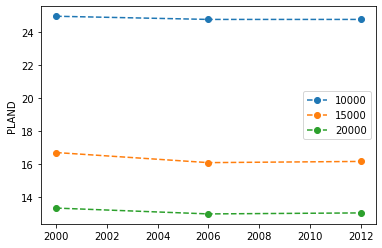

In [7]:
stba.plot_metric('proportion_of_landscape', class_val=1)

Similarly, we can produce the same plot at the landscape level by not ommiting the `class_val` argument:

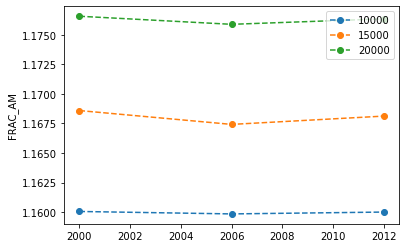

In [8]:
stba.plot_metric('fractal_dimension_am')

Although this is beyond the scope of this tutorial, note that in both of the plots above, the time series of metrics seemingly show predictable responsess to changing the spatial extent of the map.

On the other hand, we might use the `plot_landscapes` method to plot the considered landscapes for each buffer distance (row) and year (column):

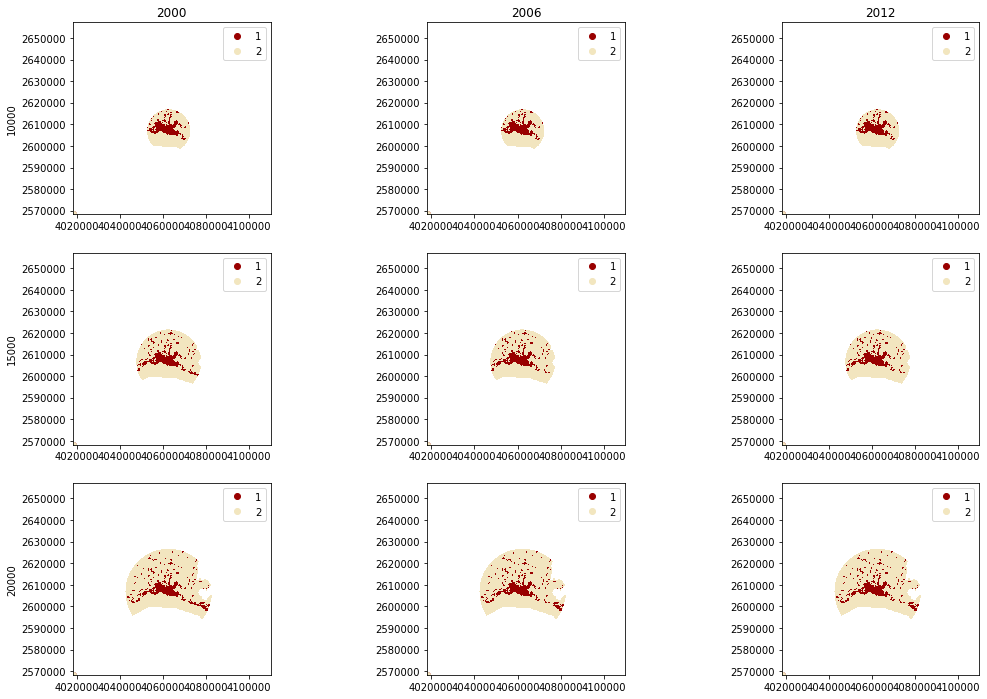

In [9]:
fig = stba.plot_landscapes()